In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, classification_report, 
ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, PredictionErrorDisplay, make_scorer)
from sklearn.utils.discovery import all_displays
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from pyrcn.echo_state_network import ESNClassifier

from scipy.stats import fisher_exact

from keras.models import Sequential
from keras.layers import LSTM, Dense

import torch

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

2024-04-24 00:19:45.935119: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('/Users/michael/Documents/MA Stats/STAT 8090/final dataset/full dataset.csv')

data.head()

,Symbol,Company_Name,Exchange,Orig_Range_Low,Orig_Range_High,Price,Shares,Offer_Amount,ipo_date,IPO_Year,...,plustwo_volume_pct,plusthree_change_pct,plusthree_volume_pct,plus90_change_pct,plus90_volume_pct,plus180_change_pct,plus180_volume_pct,d1_d180,d1_pop,d1_d180_pre_price
0,KVYO,Klaviyo,NYSE,25.0,27.0,30.0,19200000,576000000,9/20/23,2023,...,0.093943,0.007383,0.130651,-0.048713,0.053359,0.022050,0.084599,0,1,1
1,CART,Maplebear,Nasdaq,26.0,28.0,30.0,22000000,660000000,9/19/23,2023,...,0.330195,-0.049430,0.202700,0.014551,0.063364,0.039052,0.193695,1,1,1
2,NMRA,Neumora Therapeutics,Nasdaq,16.0,18.0,17.0,14710000,250070000,9/15/23,2023,...,0.064895,0.063768,0.067886,-0.000683,0.013610,-0.073217,0.260952,0,0,0
3,ARM,Arm Holdings,Nasdaq,47.0,51.0,51.0,95500000,4870500000,9/14/23,2023,...,0.191713,-0.040964,0.171408,0.003058,0.073550,0.036000,0.190792,1,1,1
4,SRFM,Surf Air Mobility,NYSE,20.0,20.0,20.0,20423622,408472440,7/27/23,2023,...,0.171561,-0.204082,0.153038,0.050420,0.001763,-0.015504,0.001312,0,0,0


In [3]:
label_encoder = LabelEncoder()
data['Exchange'] = label_encoder.fit_transform(data['Exchange'])
data['Sector'] = label_encoder.fit_transform(data['Sector'])
data['Industry'] = label_encoder.fit_transform(data['Industry'])

In [4]:
data = data.drop(columns=['Symbol', 'Company_Name', 'ipo_date', 'Country_HQ', 'Pitchbook_Number',
                          'Orig_Range_Low', 'Orig_Range_High', 'Year_Founded', 'Raised_to_IPO',
                          'ipo_date_open','ipo_date_close','ipo_date_volume','plusone_open','plusone_close',
                          'plusone_volume','plustwo_open','plustwo_close','plustwo_volume','plusthree_open','plusthree_close',
                          'plusthree_volume','plus90_open','plus90_close','plus90_volume','plus180_open','plus180_close',
                          'plus180_volume','day_one_bump','ipo_date_change_pct','ipo_date_volume_pct','plusone_change_pct',
                          'plusone_volume_pct','plustwo_change_pct','plustwo_volume_pct','plusthree_change_pct',
                          'plusthree_volume_pct','plus90_change_pct','plus90_volume_pct','plus180_change_pct','plus180_volume_pct',
                          'd1_pop', 'd1_d180'])

In [5]:
data.head()

,Exchange,Price,Shares,Offer_Amount,IPO_Year,Years_to_IPO,Price_Low_Delta,Price_High_Delta,Sector,Industry,...,market_min5,market_min4,market_min3,market_min2,market_min1,market_min0,sent_negative,sent_neutral,sent_positive,d1_d180_pre_price
0,0,30.0,19200000,576000000,2023,11,0.200000,0.111111,8,79,...,15507.15789,15230.52727,15560.37143,16104.99500,15980.94783,15786.030,1,0,0,1
1,1,30.0,22000000,660000000,2023,11,0.153846,0.071429,1,53,...,12073.46421,12446.53000,13463.77810,14033.09100,13739.49652,13585.840,1,1,0,1
2,1,17.0,14710000,250070000,2023,4,0.062500,-0.055556,5,12,...,12073.46421,12446.53000,13463.77810,14033.09100,13739.49652,13585.840,0,0,0,0
3,1,51.0,95500000,4870500000,2023,33,0.085106,0.000000,8,77,...,12073.46421,12446.53000,13463.77810,14033.09100,13739.49652,13585.840,1,1,0,1
4,0,20.0,20423622,408472440,2023,12,0.000000,0.000000,6,1,...,15827.17895,15069.23478,15507.15789,15230.52727,15560.37143,16104.995,0,0,0,0


#### Echo State Network

In [6]:
X = data.drop(columns=['d1_d180_pre_price'])
y = data['d1_d180_pre_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)

under_sampler = RandomUnderSampler()

X_train, y_train = under_sampler.fit_resample(X_train, y_train)

unique_values = set(X_train['Industry'])

# Check if at least one sample from each unique value is present in the training set
for value in unique_values:
    if value not in X_train['Industry'].unique():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
        break

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid to search
param_grid = {
    'n_reservoir': [1,2,3,4,5],  # Number of reservoir units
    'spectral_radius': [0.45, 0.5, 0.55, 0.6],  # Spectral radius
    'leakage': [0.9, 0.95, 1.0],  # Leakage rate
    'solver': ['lsqr', 'ridge'],  # Solver for linear regression
    'alpha': [0.8, 0.85, 0.9, 0.95, 1.0]  # Ridge regression parameter
}

# Initialize ESN classifier
esn = ESNClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=esn, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


GridSearchCV(cv=10,
             estimator=ESNClassifier(input_to_node=InputToNode(),
                                     node_to_node=NodeToNode(),
                                     regressor=IncrementalRegression()),
             param_grid={'alpha': [0.8, 0.85, 0.9, 0.95, 1.0],
                         'leakage': [0.9, 0.95, 1.0],
                         'n_reservoir': [1, 2, 3, 4, 5],
                         'solver': ['lsqr', 'ridge'],
                         'spectral_radius': [0.45, 0.5, 0.55, 0.6]},
             scoring='accuracy', verbose=1)

In [8]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,alpha,leakage,n_reservoir,solver,spectral_radius
56,0.540936,0.125914,1,0.80,0.95,3,lsqr,0.45
60,0.540936,0.125914,1,0.80,0.95,3,ridge,0.45
64,0.540936,0.125914,1,0.80,0.95,4,lsqr,0.45
68,0.540936,0.125914,1,0.80,0.95,4,ridge,0.45
72,0.540936,0.125914,1,0.80,0.95,5,lsqr,0.45
...,...,...,...,...,...,...,...,...
575,0.497661,0.116819,551,1.00,1.00,2,ridge,0.60
443,0.497661,0.116819,551,0.95,1.00,1,lsqr,0.60
451,0.497661,0.116819,551,0.95,1.00,2,lsqr,0.60
455,0.497661,0.116819,551,0.95,1.00,2,ridge,0.60


In [9]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'alpha': 0.8, 'leakage': 0.95, 'n_reservoir': 1, 'solver': 'lsqr', 'spectral_radius': 0.45}


In [10]:
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test_scaled)

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6190476190476191


In [12]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
cm

Confusion Matrix:


array([[ 21,  12],
       [ 76, 122]])

In [13]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (1.3073255989327468, 6.0364944950254955)
p-value for Odds Ratio: 0.007765066896439815


In [14]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.64      0.32        33
           1       0.91      0.62      0.73       198

    accuracy                           0.62       231
   macro avg       0.56      0.63      0.53       231
weighted avg       0.81      0.62      0.68       231



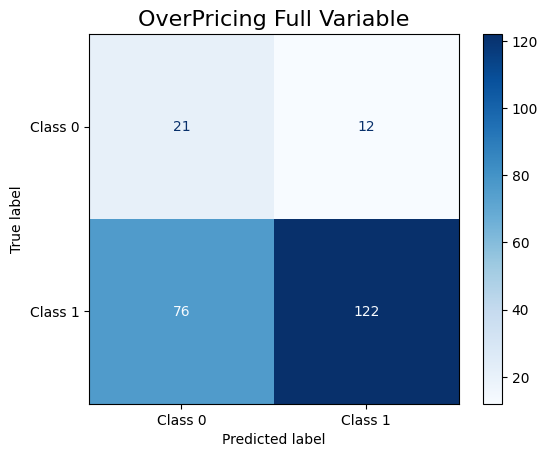

In [15]:
class_labels = ['Class 0', 'Class 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('OverPricing Full Variable', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_reservoir_tr.png', dpi=300, bbox_inches="tight")
plt.show()

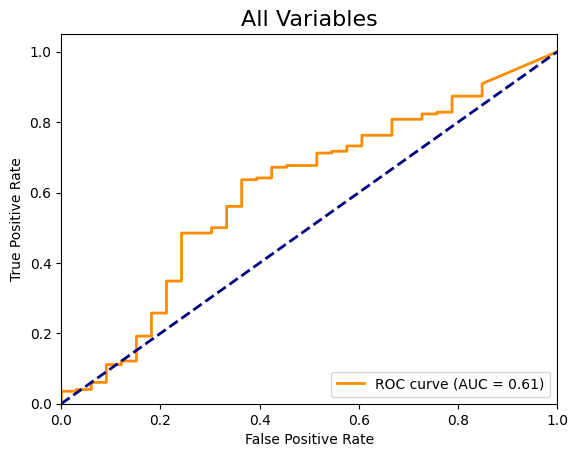

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test_scaled))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Variables', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_reservoir_tr.png', dpi=300, bbox_inches="tight")
plt.show()

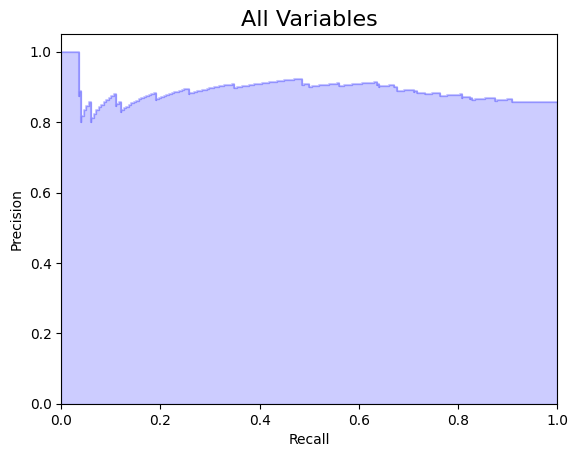

In [17]:
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test_scaled))

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_reservoir_tr.png', dpi=300, bbox_inches="tight")
plt.show()

## Feature Importance Models

### Reservior Computing

In [18]:
model = RandomForestClassifier()
model.fit(X, y)

feature_importance = pd.DataFrame(model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [19]:
fi = feature_importance[feature_importance['importance'] >= 0.01]
fi = fi.index.tolist()

In [20]:
fi_data = X[fi]

In [21]:
fi_data.head()

,Price_High_Delta,Price_Low_Delta,Offer_Amount,Shares,raise_to_ipo_ratio,Years_to_IPO,90_Trailing_IPO_plus95,Price,Industry,completed_rounds_to_ipo,...,number_of_bookrunners,market_min0,Venture_Capital_Round,market_min1,Asset Manager,Sector,Debt_OtherEquity,market_min3,sent_negative,inflation_min6
0,0.111111,0.200000,576000000,19200000,0.514286,11,16,30.0,79,8,...,8,15786.030,5,15980.94783,6,8,0,15560.37143,1,301.744
1,0.071429,0.153846,660000000,22000000,0.212219,11,15,30.0,53,17,...,5,13585.840,9,13739.49652,5,1,0,13463.77810,1,301.744
2,-0.055556,0.062500,250070000,14710000,0.290081,4,14,17.0,12,3,...,6,13585.840,2,13739.49652,3,5,0,13463.77810,0,301.744
3,0.000000,0.085106,4870500000,95500000,0.931262,33,12,51.0,77,8,...,14,13585.840,0,13739.49652,0,8,0,13463.77810,1,301.744
4,0.000000,0.000000,408472440,20423622,4.129321,12,17,20.0,1,12,...,0,16104.995,8,15560.37143,0,6,2,15507.15789,0,300.356


In [22]:
X_train, X_test, y_train, y_test = train_test_split(fi_data, y, test_size=0.3, random_state=8090)

under_sampler = RandomUnderSampler()

X_train, y_train = under_sampler.fit_resample(X_train, y_train)

unique_values = set(X_train['Industry'])

# Check if at least one sample from each unique value is present in the training set
for value in unique_values:
    if value not in X_train['Industry'].unique():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
        break

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid to search
param_grid = {
    'n_reservoir': [1,2,3,4,5], 
    'spectral_radius': [0.45, 0.5, 0.55, 0.6],  
    'leakage': [0.9, 0.95, 1.0],  
    'solver': ['lsqr', 'ridge'], 
    'alpha': [0.8, 0.85, 0.9, 0.95, 1.0] 
}

# Initialize ESN classifier
esn = ESNClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=esn, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


GridSearchCV(cv=10,
             estimator=ESNClassifier(input_to_node=InputToNode(),
                                     node_to_node=NodeToNode(),
                                     regressor=IncrementalRegression()),
             param_grid={'alpha': [0.8, 0.85, 0.9, 0.95, 1.0],
                         'leakage': [0.9, 0.95, 1.0],
                         'n_reservoir': [1, 2, 3, 4, 5],
                         'solver': ['lsqr', 'ridge'],
                         'spectral_radius': [0.45, 0.5, 0.55, 0.6]},
             scoring='accuracy', verbose=1)

In [24]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,alpha,leakage,n_reservoir,solver,spectral_radius
0,0.710819,0.139025,1,0.8,0.9,1,lsqr,0.45
8,0.710819,0.139025,1,0.8,0.9,2,lsqr,0.45
12,0.710819,0.139025,1,0.8,0.9,2,ridge,0.45
4,0.710819,0.139025,1,0.8,0.9,1,ridge,0.45
24,0.710819,0.139025,1,0.8,0.9,4,lsqr,0.45
...,...,...,...,...,...,...,...,...
327,0.661404,0.171843,551,0.9,1.0,1,ridge,0.60
591,0.661404,0.171843,551,1.0,1.0,4,ridge,0.60
583,0.661404,0.171843,551,1.0,1.0,3,ridge,0.60
599,0.661404,0.171843,551,1.0,1.0,5,ridge,0.60


In [25]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'alpha': 0.8, 'leakage': 0.9, 'n_reservoir': 1, 'solver': 'lsqr', 'spectral_radius': 0.45}


In [26]:
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test_scaled)

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6363636363636364


In [28]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
cm

Confusion Matrix:


array([[ 22,  11],
       [ 73, 125]])

In [29]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (1.5710801640553613, 7.465105533888311)
p-value for Odds Ratio: 0.0019302138679031492


In [30]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.67      0.34        33
           1       0.92      0.63      0.75       198

    accuracy                           0.64       231
   macro avg       0.58      0.65      0.55       231
weighted avg       0.82      0.64      0.69       231



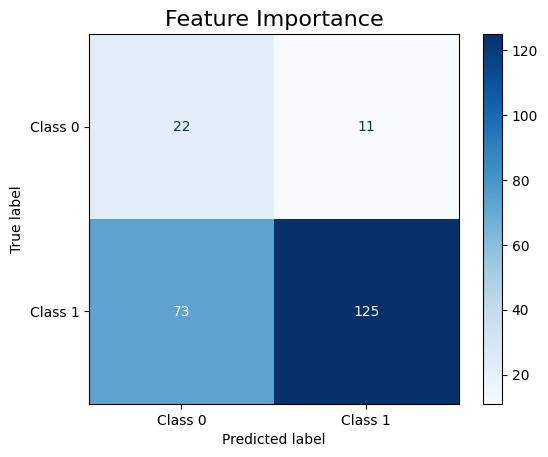

In [32]:
class_labels = ['Class 0', 'Class 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_reservoir_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

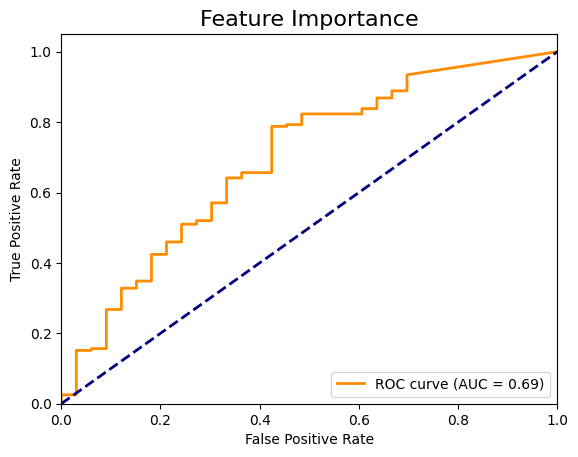

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test_scaled))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Feature Importance', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_reservoir_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

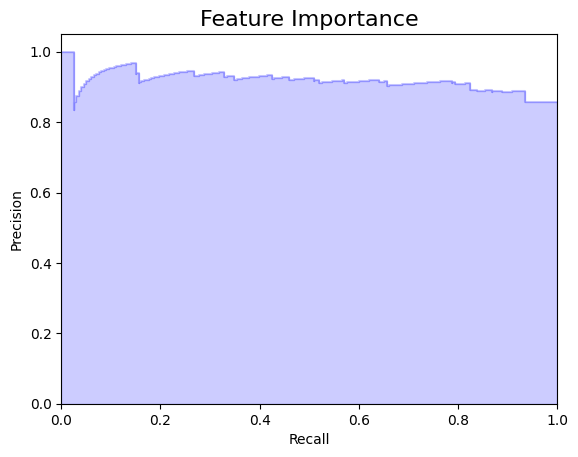

In [34]:
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test_scaled))

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_reservoir_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

---
### End of Notebook